# Flower Classification with VGG16
### Author: Salma OUARDI
Dataset: [Flowers Recognition](https://www.kaggle.com/datasets/alxmamaev/flowers-recognition)

### On import la base de données depuis Kaggle

In [17]:
# reset data dir
!rm -rf data/*

In [ ]:
# environment 

# originally 240,240
# size=(150,150)
image_w = 150
image_h = 150

In [ ]:
%pip install kaggle
%pip install pandas
%pip install seaborn
%pip install scipy


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

# ! kaggle datasets download alxmamaev/flowers-recognition
# ! unzip flowers-recognition.zip

In [8]:
!rm /root/.keras/datasets/flower_photos/LICENSE.txt
# !ls -l /root/.keras/datasets/flower_photos

!rm -rf /kaggle/working/dataset
!cp -r /root/.keras/datasets/flower_photos/ /kaggle/working/dataset
!ls -l /kaggle/working/dataset

DATASET_DIR = '/kaggle/working/dataset'

rm: cannot remove '/root/.keras/datasets/flower_photos/LICENSE.txt': Permission denied
cp: cannot stat '/root/.keras/datasets/flower_photos/': Permission denied
ls: cannot access '/kaggle/working/dataset': No such file or directory


### On verifie qu'on a un GPU 

In [1]:
#' ' means CPU whereas '/device:G:0' means GPU
import tensorflow as tf
tf.test.gpu_device_name()

2024-11-21 18:42:30.696311: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-21 18:42:31.541091: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdirectml.d6f03b303ac3c4f2eeb8ca631688c9757b361310.so
2024-11-21 18:42:31.541146: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdxcore.so
2024-11-21 18:42:31.551674: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libd3d12.so
2024-11-21 18:42:35.190590: I tensorflow/c/logging.cc:34] DirectML device enumeration: found 2 compatible adapters.
2024-11-21 18:42:35.488639: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the fo

'/device:GPU:0'

In [10]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

ln: failed to create symbolic link '/usr/bin/nvidia-smi': Permission denied
  Using cached GPUtil-1.4.0-py3-none-any.whl

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
  Using cached humanize-4.11.0-py3-none-any.whl (128 kB)

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Gen RAM Free: 12.7 GB  | Proc size: 611.4 MB
GPU RAM Free: 3239MB | Used: 716MB | Util  17% | Total 4096MB


### On import les librairies

In [2]:
import os
import shutil
from os.path import isfile, join, abspath, exists, isdir, expanduser
from os import listdir, makedirs, getcwd, remove
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import matplotlib.image as mimg

import tensorflow as tf
print(tf.__version__)
# tensorflow 2.16 allows 
# from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array

from keras.utils import load_img, img_to_array
from keras import optimizers

from keras import layers
from keras import models
from keras import optimizers


2.10.0


In [6]:
# download the dataset

!rm -rf /home/logic/.keras/datasets/*

import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)

print(data_dir)

data_dir = pathlib.Path(data_dir).with_suffix('')
data_dir

228813984/228813984 [==============================] - 20s 0us/step
/home/logic/.keras/datasets/flower_photos.tar


PosixPath('/home/logic/.keras/datasets/flower_photos')

In [11]:
# original dataset folder, you can see above
DATASET_DIR = data_dir

flowers_path = str(pathlib.Path(DATASET_DIR)) 
flowers_path

# clean up the path
!rm -rf {flowers_path}/LICENSE.txt

!ls -l {flowers_path}

total 224
drwx------ 2 logic logic 36864 Feb 11  2016 daisy
drwx------ 2 logic logic 53248 Feb 11  2016 dandelion
drwx------ 2 logic logic 36864 Feb 11  2016 roses
drwx------ 2 logic logic 36864 Feb 11  2016 sunflowers
drwx------ 2 logic logic 45056 Feb 11  2016 tulips


In [12]:
# Check for the directory and if it doesn't exist, make one.
cache_dir = expanduser(join('~', '.keras'))
if not exists(cache_dir):
    makedirs(cache_dir)
    
# make the models sub-directory
models_dir = join(cache_dir, 'models')
if not exists(models_dir):
    makedirs(models_dir)

## On prepare explore la dataset

In [13]:
# Each species of flower is contained in a separate folder. Get all the sub directories
flower_types = os.listdir(flowers_path)
print("Types of flowers found: ", len(flower_types))
print("Categories of flowers: ", flower_types)

Types of flowers found:  5
Categories of flowers:  ['daisy', 'dandelion', 'sunflowers', 'tulips', 'roses']


In [14]:
# A list that is going to contain tuples: (species of the flower, corresponding image path)
flowers = []

for species in flower_types:
    # Get all the file names
    all_flowers = os.listdir(flowers_path +"/"+ species)
    # Add them to the list
    for flower in all_flowers:
        flowers.append((species, str(flowers_path +"/"+species) + '/' + flower))

# Build a dataframe        
flowers = pd.DataFrame(data=flowers, columns=['category', 'image'], index=None)
flowers.head()

,category,image
0,daisy,/home/logic/.keras/datasets/flower_photos/dais...
1,daisy,/home/logic/.keras/datasets/flower_photos/dais...
2,daisy,/home/logic/.keras/datasets/flower_photos/dais...
3,daisy,/home/logic/.keras/datasets/flower_photos/dais...
4,daisy,/home/logic/.keras/datasets/flower_photos/dais...


In [15]:
# Let's check how many samples for each category are present
print("Total number of flowers in the dataset: ", len(flowers))
fl_count = flowers['category'].value_counts()
print("Flowers in each category: ")
print(fl_count)

Total number of flowers in the dataset:  3670
Flowers in each category: 
category
dandelion     898
tulips        799
sunflowers    699
roses         641
daisy         633
Name: count, dtype: int64


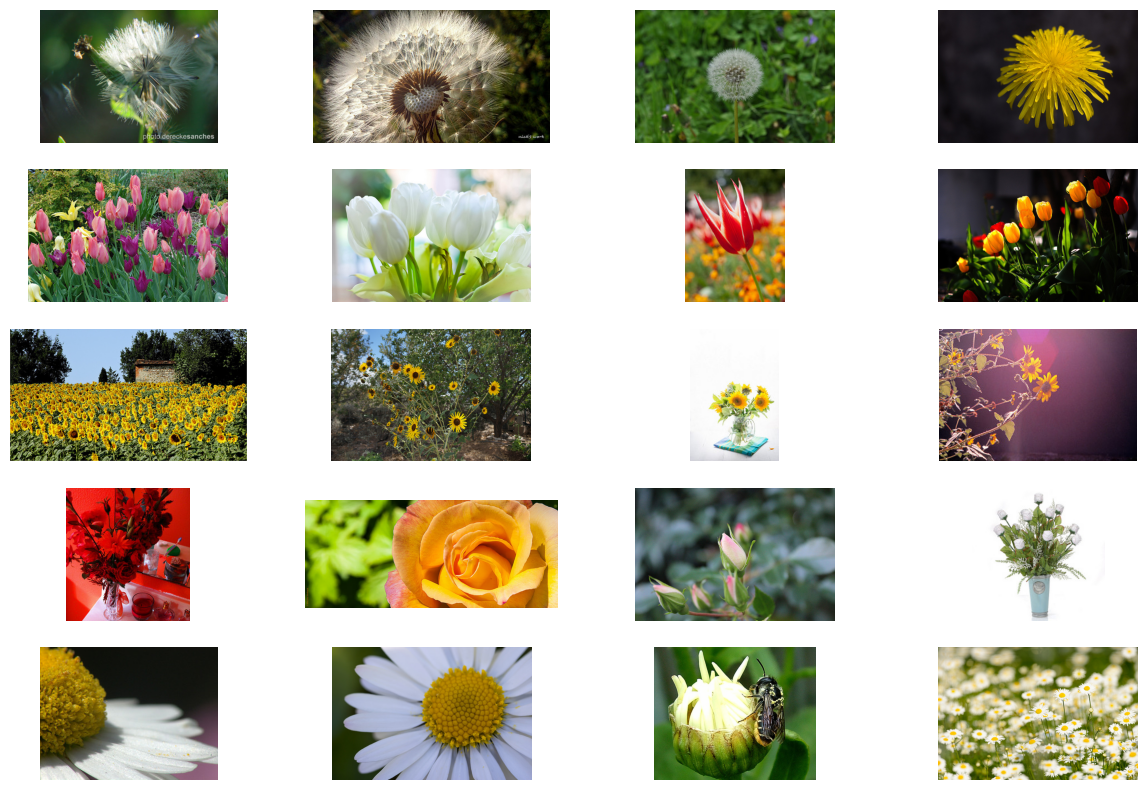

In [16]:
# Let's visualize some flowers from each category

# A list for storing names of some random samples from each category
random_samples = []

# Get samples fom each category 
for category in fl_count.index:
    samples = flowers['image'][flowers['category'] == category].sample(4).values
    for sample in samples:
        random_samples.append(sample)

# Plot the samples
f, ax = plt.subplots(5,4, figsize=(15,10))
for i,sample in enumerate(random_samples):
    ax[i//4, i%4].imshow(mimg.imread(random_samples[i]))
    ax[i//4, i%4].axis('off')
plt.show()    

### On va créer deux dossier 'Train' et 'Valid' pour notre modéle

In [18]:
# Make a parent directory `data` and two sub directories `train` and `valid`
%mkdir -p data/train
%mkdir -p data/valid

# Inside the train and validation sub=directories, make sub-directories for each catgeory
%cd data
%mkdir -p train/daisy
%mkdir -p train/tulips
%mkdir -p train/sunflowers
%mkdir -p train/roses
%mkdir -p train/dandelion

%mkdir -p valid/daisy
%mkdir -p valid/tulips
%mkdir -p valid/sunflowers
%mkdir -p valid/roses
%mkdir -p valid/dandelion

%cd ..

/home/logic/_wsl_workspace/google-colab-playlist/kaggle/data


/home/logic/.pyenv/versions/3.9.20/envs/jupyter-tf-kaggle/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/home/logic/_wsl_workspace/google-colab-playlist/kaggle


### On import nos catégories dans les deux dossiers 

In [19]:
for category in fl_count.index:
    samples = flowers['image'][flowers['category'] == category].values
    #perm = np.random.permutation(samples)
    # Copy first 100 samples to the validation directory and rest to the train directory

    print(samples[0])
    
    for i in range(100):
        name = samples[i].split('/')[-1]
        shutil.copyfile(samples[i],'./data/valid/' + str(category) + '/'+ name)
    for i in range(100,len(samples)):
        name = samples[i].split('/')[-1]
        shutil.copyfile(samples[i],'./data/train/' + str(category) + '/' + name)

/home/logic/.keras/datasets/flower_photos/dandelion/2596413098_7ef69b7e1d_m.jpg
/home/logic/.keras/datasets/flower_photos/tulips/8712282563_3819afb7bc.jpg
/home/logic/.keras/datasets/flower_photos/sunflowers/4689061249_6498da5013.jpg
/home/logic/.keras/datasets/flower_photos/roses/3829990289_c0c3821e4d_m.jpg
/home/logic/.keras/datasets/flower_photos/daisy/3468498624_d082f99e98.jpg


### Comme modéle, on utilise VGG16 qui est un modéle Pretrained

In [ ]:
from tensorflow.keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(image_w, image_h, 3))

In [23]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [24]:
base_dir = './data'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'valid')

## Feature Extraction

In [25]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(5, activation='softmax'))

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 5)                 6

In [ ]:
batch_size = 32
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'data/train',
        target_size=(image_w, image_h),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical')  # more than two classes

validation_generator = test_datagen.flow_from_directory(
        'data/valid',
        target_size=(image_w, image_h),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle = False
)

Found 3170 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


In [28]:
from tensorflow.keras.optimizers import Adam

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.0001),
              metrics=['acc'])

In [ ]:
history = {}

history = model.fit(
  train_generator,
  epochs=2, # originally 30 epochs
  validation_data=validation_generator)

Epoch 1/2


2024-11-21 18:48:28.317593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-21 18:48:28.444415: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-21 18:48:28.444455: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 1, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-21 18:48:28.444485: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 17714 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-11-21 18:48:28.444498: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

 82/100 [=======================>......] - ETA: 28s - loss: 1.6208 - acc: 0.2483

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

f, axes = plt.subplots(1,2,figsize=(14,4))

axes[0].plot(epochs, acc, 'bo', label='Training acc')
axes[0].plot(epochs, val_acc, 'b', label='Validation acc')
axes[0].legend()

axes[1].plot(epochs, loss, 'bo', label='Training loss')
axes[1].plot(epochs, val_loss, 'b', label='Validation loss')
axes[1].yaxis.set_label_position("right")
axes[1].legend()

plt.show()

In [ ]:
model_2_val = val_acc[-1]
print("Validation Accuracy: ", model_2_val)

# Fine Tuning

In [ ]:
conv_base.summary()

In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.0001),
              metrics=['acc'])

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=3,# originally 6 epochs
    validation_data=validation_generator,
    validation_steps=50)

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

f, axes = plt.subplots(1,2,figsize=(14,4))

axes[0].plot(epochs, acc, 'bo', label='Training acc')
axes[0].plot(epochs, val_acc, 'b', label='Validation acc')
axes[0].legend()

axes[1].plot(epochs, loss, 'bo', label='Training loss')
axes[1].plot(epochs, val_loss, 'b', label='Validation loss')
axes[1].yaxis.set_label_position("right")
axes[1].legend()

plt.show()

In [ ]:
model_3_val = val_acc[-1]
print("Validation Accuracy: ", model_3_val)

### 85% Accuracy using VGG16.